# Peak finding

Playing with Logan's data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt
from scipy.stats import linregress
from scipy import optimize
import pandas as pd

In [2]:
# define a digital record class
class digitizer_record:
    def __init__(self,timestamp,event,npoints,t,v,rf):
        self.timestamp=timestamp    # timestamp
        self.event=event            # event number
        self.npoints=npoints        # Number of data points
        self.t = t                  # array of time values (ns)
        self.v = v                  # array of input voltages (digitizer units)
        self.rf = rf                # array of RF values (digitizer units)

In [3]:
# define a data class for hits
class hit():
    def __init__(self,index,time,peak,area,tot):
        self.index=index         # pointer to the hit (first point over threshold)
        self.time=time           # Best time of peak (from fit)
        self.peak=peak           #peak value
        self.area=area           #total area of peak
        self.tot=tot             #time over threshold

In [4]:
# Hit finding routine
# Inputs:
#    t:  array of time points
#    v:  array of values
#    thresh: threshold to be called a hit
#    nped:  number of points to use for pedestal
#    ngap: number of points to skip after the fit to look for a hit
#    npeak: minimum number of points over threshold to qualify as a peak
#    nrise: number of rising points to fit to find time
# Routine will do a running average of (nped) points to calculate 
# the pedestal.  It will proct this (ngap) points ahead and look for at least (npeak) consecutive
# points above the projected pedestal.  The first point over threshold will be counted as 
# the time of the hit.  It will then calculate the peak value, area, and time over threshold
# for the hit.  The hit will be ignored if it hasn't fallen below threshold before the
# end of the record.
#
# The first (nrise) points of the hit will be fit, and the intercept with the pedestal 
# will be used as the precision time.
#
def findHits(t,v,thresh,nped,ngap,npeak,nrise):
    hits = []
    npoints = len(t)
    istart = 0
    idx = 0
    while istart<npoints:
        nahead = nped+ngap+npeak     # make sure we have enough samples to find a peak
        if (istart+nahead>=npoints):  
            break
        itest = istart+nped+ngap
        testt = t[itest:itest+npeak]
        testv = v[itest:itest+npeak]
        # Find the mean of the pedestal points and subtract it from the test vector
        pedmean = v[istart:(istart+nped)].mean()
        testv = testv-pedmean
        # A peak is found if all of these points are are above threshold
        if np.all(testv > thresh):
            thit = t[itest]  # itest marks the beginning of the hit
            # Only recored the hit if we see the whole thing
            peak = 0.
            area = 0.
            # print("Found a hit at t=%f"%thit)
            for idx in range(itest,npoints):
                # calculate the signal above threshold
                vpoint = v[idx]-pedmean
                if vpoint < thresh:
                    break
                if v[idx]>peak:
                    peak = v[idx]   # Find the peak value
                area += vpoint      # Find the total area over threshold (arbitrary units)
                tot = t[idx]-thit   # Time over threshold (ns)
            # ignore this hit if it didn't go back below threshold before the end
            if idx<(npoints-1):
                # fit the first (nrise) points of the peak and project to get the time
                pfit = linregress(t[itest:itest+nrise],v[itest:itest+nrise])
                # refine thit by finding where the fit and the pedestal intercept
                tfit = (pedmean-pfit.intercept)/(pfit.slope)
                # now pack it all into the hits vector
                hits.append(hit(itest,tfit,peak,area,tot))
            # Update to search for the next point
            istart = idx+1
        else:
            istart+=1
        # print("istart = %d"%istart)
    return(hits)

In [5]:
# Wrapper for Butterworth filter (based on ChaptGPT)
def filter(data, cutoff_freq, fs, btype='low',order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [6]:
# animation to show that application is still running
def working_anim(index, refresh): #Just command line animation to see if code is hung or slowing
    if (index%400 == 0):
        print("Working  |", end = "\r")
    if (index%400 == int(refresh/4)):
        print("Working  /", end = "\r")
    if (index%400 == int(refresh/2)):
        print("Working  -", end = "\r")
    if (index%400 == int(refresh*3/4)):
        print("Working  \\", end = "\r")

In [7]:
def transform_data(raw_data): #chatGPT wrote this
    str_data = [string.split(',') for string in raw_data]
    unformatted_data = [[int(sublist[0]), float(sublist[1]), float(sublist[2])] for sublist in str_data]
    data = list(map(list, zip(*unformatted_data)))
    return data

In [8]:
# routine to find the period and offset from the RF values
def find_period(times,rf):
    trigger_times = []  # Times when the sine wave crosses the node
    meanrf = rf.mean()
    last_rfval = 50000.
    for i in range(len(rf)):
        rfval = rf[i]-meanrf   # Look for zero crossing
        if last_rfval <=0 and rfval>0:
            trigger_times.append(times[i])
        last_rfval = rfval
                    
    # Do a fit to determin the period and offset
    fit = linregress(np.arange(len(trigger_times)),trigger_times)
    return (fit.slope,fit.intercept)
    

In [9]:
# Routine to extract data from the file.  Returns a list of
# "digitizer_record" class.
#
def extract_data(file_in,max_records=-1):  
    index = 0
    all_records = []
    with open(file_in, 'r') as file:                                #Open file     
        while True:                

############Get the trace from the file
            line = file.readline().strip()                          #Readline
            
            if not any(line):                                       #Check to see if input file line is empty (aka end of file)
                break       
                    
            if (line[:6] == "Record"):                              #Check for start of trace
                n_data = int(line.split(":")[1].strip())            #Get points per trace
                
                nline = file.readline().strip()             
                n_event = int(nline.split(":")[1].strip())          #Get the event number
                
                nline = file.readline().strip()
                t_event = int(nline.split(":")[1].strip())          #Get the event time
                
                nline = file.readline().strip()
                header = [ item for item in nline.split(',')]       #get the header for the data
               
                line_data = [None]*n_data                           #Create an empty list with size of points in trace
                for n in range(0,n_data):       
                    line_data[n] = file.readline().strip()          #Add each point into a list
                
                data = np.asarray(transform_data(line_data))        #transform list of strings to correct format
                
    
            else:                                                   #Check to see if we are synconized
                print("Something went wrong\nLine reading got desynced")
                input()
            # Convert the raw data records to numpy arrays
            t = np.array(data[0]/10.)  # time in ns
            v = np.array(data[1])      # signal
            rf = np.array(data[2])     # RF
            
            # pack everything into a record
            all_records.append(digitizer_record(t_event,n_event,n_data,t,v,rf))
            #needless animation for fun
            index += 1
            working_anim(index, 400)
            if index==max_records:
                break
    return (all_records)

In [10]:
# Copied from Logan's code
target_dir = r"./"
target_file = r"WaveDump_Data_15_25_15_clipped.csv"
all_data = extract_data(target_dir+target_file,0) 
print("\nExtracted %d records."%len(all_data))

Working  -
Extracted 664 records.


Extracted record 0: event number 151734, timestamp=988999378, npoints=1024
    RF period: 44.45 ns, RF offset: 9.01 ns


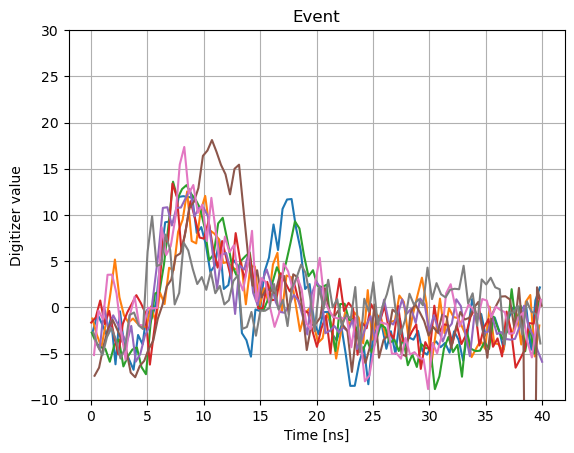

    Number of hits found: 8
      index = 88, itime = 6.189091, time = 4.589392, peak = 12.027725, area = 149.456102, tot=5.200000
      index = 201, itime = 6.938182, time = 5.901211, peak = 12.542595, area = 147.200457, tot=6.400000
      index = 309, itime = 5.687273, time = 4.435333, peak = 13.597003, area = 265.235179, tot=8.800000
      index = 422, itime = 6.436364, time = 5.443864, peak = 13.396256, area = 136.852017, tot=5.600000
      index = 532, itime = 5.985455, time = 4.580652, peak = 12.771441, area = 158.644791, tot=4.800000
      index = 645, itime = 6.734545, time = 5.119836, peak = 18.105846, area = 360.845404, tot=10.400000
      index = 755, itime = 6.283636, time = 9.772688, peak = 17.356258, area = 148.841430, tot=4.800000
      index = 978, itime = 6.581818, time = 4.804898, peak = 7.238709, area = 144.973947, tot=6.000000
Extracted record 1: event number 151735, timestamp=989233706, npoints=1024
Time between records = 234328
    RF period: 44.40 ns, RF offset: 

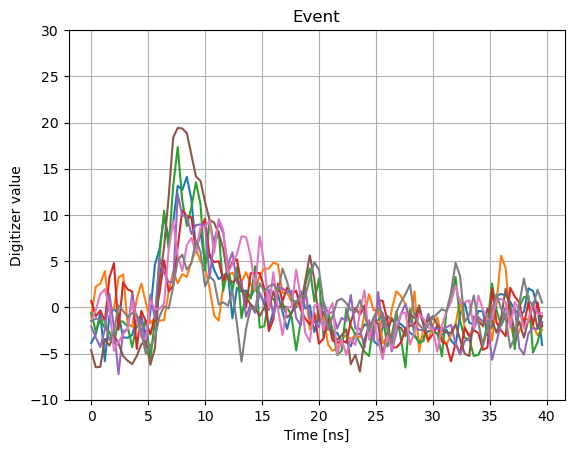

    Number of hits found: 6
      index = 72, itime = 5.600000, time = 4.577823, peak = 14.117077, area = 169.417579, tot=6.400000
      index = 295, itime = 6.000000, time = 42.362479, peak = 17.347588, area = 166.240143, tot=5.200000
      index = 410, itime = 7.600000, time = 5.760636, peak = 10.511068, area = 78.776490, tot=3.600000
      index = 628, itime = 6.000000, time = 5.472204, peak = 19.429441, area = 260.476170, tot=7.200000
      index = 741, itime = 6.800000, time = 18.988269, peak = 9.569058, area = 169.108567, tot=7.200000
      index = 1005, itime = 23.600000, time = 8.051807, peak = 10.847299, area = 97.553754, tot=4.000000
Extracted record 2: event number 151736, timestamp=989467128, npoints=1024
Time between records = 233422
    RF period: 44.47 ns, RF offset: 39.96 ns


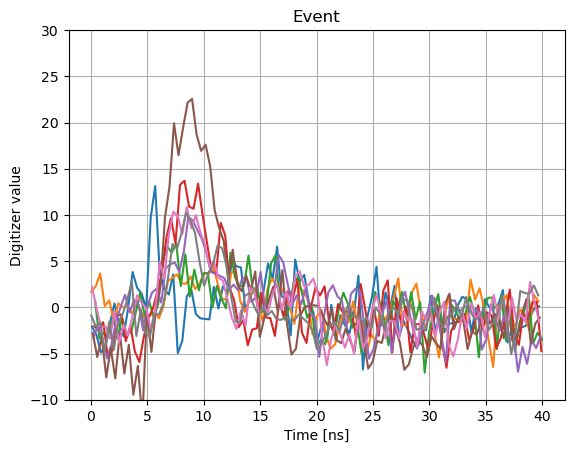

    Number of hits found: 4
      index = 388, itime = 6.311111, time = 5.455027, peak = 13.698531, area = 165.948727, tot=5.600000
      index = 500, itime = 6.644444, time = 43.825975, peak = 9.785261, area = 82.069470, tot=4.000000
      index = 610, itime = 6.177778, time = 5.603676, peak = 22.563212, area = 348.849736, tot=8.400000
      index = 723, itime = 6.911111, time = 3.461077, peak = 10.864012, area = 97.162413, tot=4.000000
Extracted record 3: event number 151737, timestamp=989721454, npoints=1024
Time between records = 254326
    RF period: 44.44 ns, RF offset: 6.60 ns


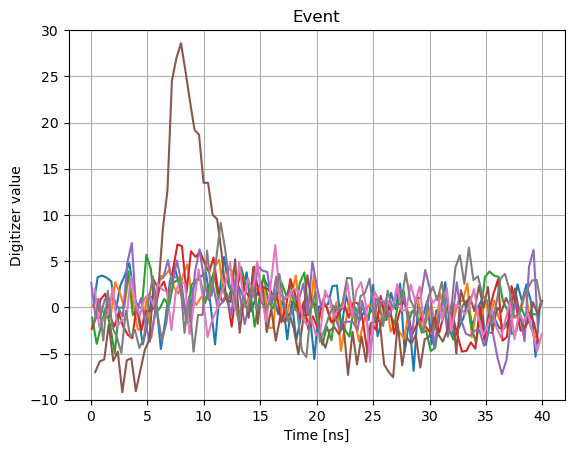

    Number of hits found: 1
      index = 636, itime = 5.578182, time = 4.443048, peak = 28.578200, area = 370.670018, tot=7.200000
Extracted record 4: event number 151738, timestamp=989974808, npoints=1024
Time between records = 253354
    RF period: 44.44 ns, RF offset: 1.11 ns


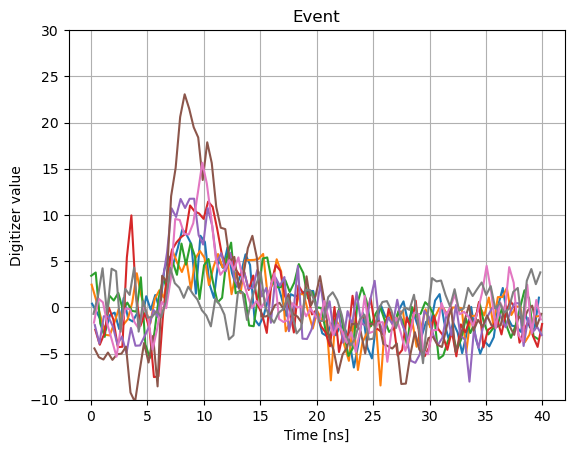

    Number of hits found: 5
      index = 403, itime = 6.778182, time = 5.449144, peak = 11.438938, area = 143.964636, tot=6.000000
      index = 514, itime = 6.739394, time = 4.903899, peak = 11.756414, area = 156.956670, tot=5.600000
      index = 624, itime = 6.300606, time = 5.690439, peak = 23.056327, area = 352.784547, tot=8.400000
      index = 738, itime = 7.461818, time = 13.046527, peak = 15.646888, area = 145.036288, tot=5.600000
      index = 1003, itime = 24.584242, time = 21.375835, peak = 9.092586, area = 105.996539, tot=4.800000
Extracted record 5: event number 151739, timestamp=990221080, npoints=1024
    RF period: 44.47 ns, RF offset: 28.36 ns
    Number of hits found: 9
Extracted record 6: event number 151740, timestamp=990477368, npoints=1024
    RF period: 44.46 ns, RF offset: 8.30 ns
    Number of hits found: 8
Extracted record 7: event number 151741, timestamp=990774118, npoints=1024
    RF period: 44.44 ns, RF offset: 43.75 ns
    Number of hits found: 5
Extrac

<Figure size 640x480 with 0 Axes>

In [11]:
# create the rows of hits to convert into a Panda table
hit_rows = []
num_hits = [] # Number of hits per record

last_timestamp = -1
irecord = 0
ndump = 5 # number of events to dump detailed information for
for record in all_data:
    print("Extracted record %d: event number %d, timestamp=%d, npoints=%d"%(irecord, record.event,
                                                                            record.timestamp,record.npoints))
    if last_timestamp>0:
        if irecord<ndump:
            print("Time between records = %d"%(record.timestamp-last_timestamp))
    last_timestamp = record.timestamp
    
    t = record.t   # Array of times in ns
    v = record.v   # Array of voltages in digitizer units
    rf = record.rf # Array of RF voltages in digitizer units
    
    # determine the period and offset
    period,offset = find_period(t,rf)
    print("    RF period: %.2f ns, RF offset: %.2f ns"%(period,offset))
    #
    # Apply filters
    #
    fs = 2.5e9    # Sampling frequency (Hz)
    highpass_cutoff = 20e6  # Cutoff frequency (Hz)
    lowpass_cutoff = 250e6  # Lowpass frequency (Hz)
    # Apply highpass data first
    highpass_data = filter(v,highpass_cutoff,fs,'high',6)
    # Then apply lowpass to make a bandpass
    bandpass_data = filter(highpass_data,lowpass_cutoff,fs,'low',6)
                    
   # kludge in the individual wave plots here
    period_time = t-offset-20.  # By trial and error, this puts the traces
                                # in about the right spot
    period_time = period_time%period
    # Print out individual waveforms for each record of the first few
    if irecord<ndump:
      # Break up the record into individual waveforms
        last_time = -1.
        n_plot = int(40*2.5) # 40 ns
        for i in range(len(period_time)-n_plot):  # make sure there are enough samples to plot
            # see of time has looped back
            #print("in i loop")
            if period_time[i]<last_time:
                #print("in plot loop")
                plt.plot(period_time[i:(i+n_plot)],highpass_data[i:(i+n_plot)])
            last_time = period_time[i]

        plt.ylim(-10,30)
        plt.title("Event")
        plt.xlabel("Time [ns]")
        plt.ylabel("Digitizer value")
        plt.grid()
        plt.draw()
        plt.pause(1)
        plt.clf()
    # Now find the times of the hits
    hits = findHits(t,highpass_data,5.,20,4,10,3)
    print("    Number of hits found: %d"%len(hits))    
    num_hits.append(len(hits))
    
    for h in hits:
        period_itime = t[h.index] - offset-20.
        period_itime = period_itime%period     # Time based on first bin over threshold
        period_time = h.time - offset-20.
        period_time = period_time%period       # Time based on fit
        # stuff all hit data into a panda row
        row = {'irecord':irecord,
               'timestamp':record.timestamp,
               'index':h.index,
               'period_itime':period_itime,
               'period_time':period_time,
               'peak':h.peak,
               'area':h.area,
               'tot':h.tot}
        hit_rows.append(row)
        if irecord<ndump:
            print("      index = %d, itime = %f, time = %f, peak = %f, area = %f, tot=%f"%(h.index,period_itime,period_time,
                                                                     h.peak,h.area, h.tot))
    irecord += 1

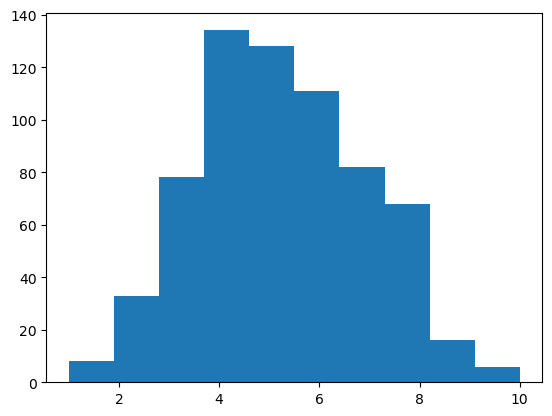

In [12]:
dum = plt.hist(num_hits)

In [13]:
# Now let's do a fit of this distribution to a Gaussian
def fit_func(x,N,mu,sig):
    val = N*np.exp(-(x-mu)**2/2/sig**2)
    val = val/sig/np.sqrt(2*np.pi)
    return val

Best fit: Chi2/NDF=2.585
    N=740.7 +- 13.608079
    mu=6.66 +- 0.011225
    sig=0.595 +- 0.008113


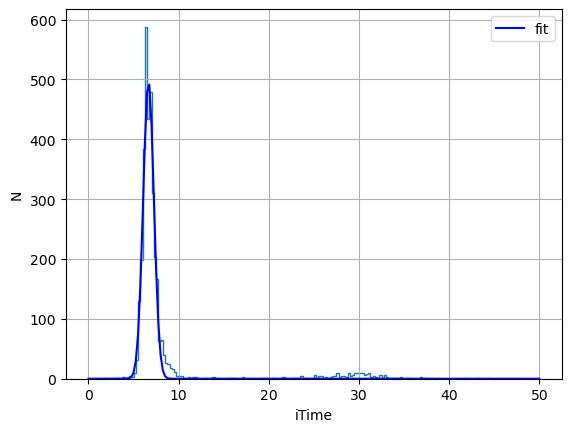

In [14]:
# Convert the list of rows to a Panda table
hit_df = pd.DataFrame(hit_rows)

Nbins=200

hist,bins=np.histogram(hit_df.period_itime,Nbins,(0.,50.))
plt.stairs(hist,bins)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin

dum=plt.grid()
p0 = np.array([600.,7.,1.])
par, cov = optimize.curve_fit(fit_func, binloc, hist, p0=p0,sigma=hist_error,absolute_sigma=True)
pred = fit_func(binloc,par[0],par[1],par[2])

NDF = Nbins-3 # 3-parameter fit.  Normalization no longer a constraint
chi2 = ((pred-hist)**2/hist_error**2).sum()/NDF
perr = np.sqrt(np.diag(cov))
print('Best fit: Chi2/NDF=%.3f'%(chi2))
print('    N=%.1f +- %1f'%(par[0],perr[0]))
print('    mu=%.2f +- %2f'%(par[1],perr[1]))
print('    sig=%.3f +- %3f'%(par[2],perr[2]))

xlin = np.linspace(0.,50.,201)
pl=plt.plot(xlin,fit_func(xlin,par[0],par[1],par[2]),"b",label="fit")
plt.xlabel('iTime')
plt.ylabel('N')
plt.legend()

dum=plt.draw()
plt.show()

Best fit: Chi2/NDF=5.269
    N=608.5 +- 12.333674
    mu=5.45 +- 0.016230
    sig=0.783 +- 0.013071


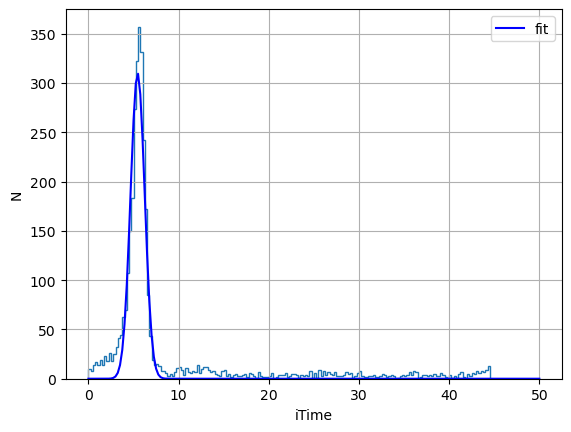

In [15]:
# Convert the list of rows to a Panda table
hit_df = pd.DataFrame(hit_rows)

Nbins=200

hist,bins=np.histogram(hit_df.period_time,Nbins,(0.,50.))
plt.stairs(hist,bins)
hist_error = np.sqrt(hist)
hist_error = np.clip(hist_error,1.,None) # If the sqrt is 0, set it to 1.
binsize = bins[1]-bins[0]
binloc = bins[0:-1]+.5*binsize    # Move location to the middle of the bin

dum=plt.grid()
p0 = np.array([600.,7.,1.])
par, cov = optimize.curve_fit(fit_func, binloc, hist, p0=p0,sigma=hist_error,absolute_sigma=True)
pred = fit_func(binloc,par[0],par[1],par[2])

NDF = Nbins-3 # 3-parameter fit.  Normalization no longer a constraint
chi2 = ((pred-hist)**2/hist_error**2).sum()/NDF
perr = np.sqrt(np.diag(cov))
print('Best fit: Chi2/NDF=%.3f'%(chi2))
print('    N=%.1f +- %1f'%(par[0],perr[0]))
print('    mu=%.2f +- %2f'%(par[1],perr[1]))
print('    sig=%.3f +- %3f'%(par[2],perr[2]))

xlin = np.linspace(0.,50.,201)
pl=plt.plot(xlin,fit_func(xlin,par[0],par[1],par[2]),"b",label="fit")
plt.xlabel('iTime')
plt.ylabel('N')
plt.legend()

dum=plt.draw()
plt.show()

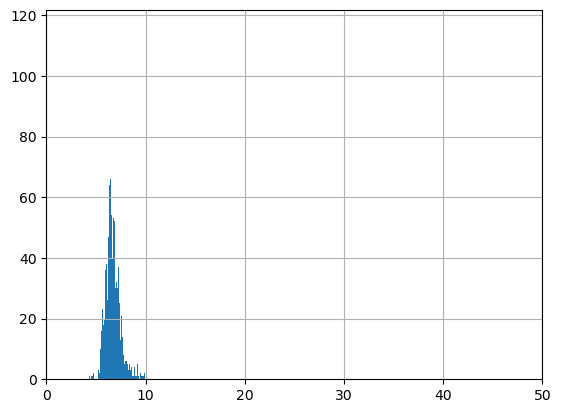

In [50]:
intime = hit_df.query("period_itime>4. and period_itime<10")
dum=plt.hist(intime.period_itime,bins=200)
dum=plt.xlim(0,50.)
dum=plt.grid()

dum=plt.draw()

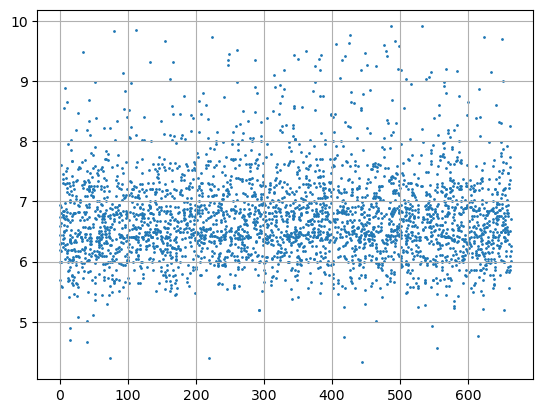

In [51]:
dum=plt.scatter(intime.irecord,intime.period_itime,s=1)
dum=plt.grid()

dum=plt.draw()            
            
            

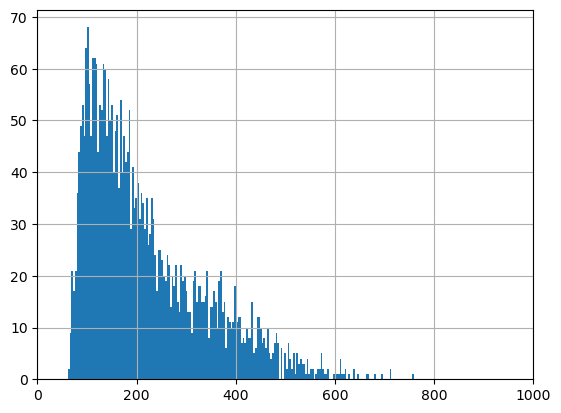

In [52]:
dum=plt.hist(intime.area,bins=200)
dum=plt.xlim(0,1000.)
dum=plt.grid()

dum=plt.draw()

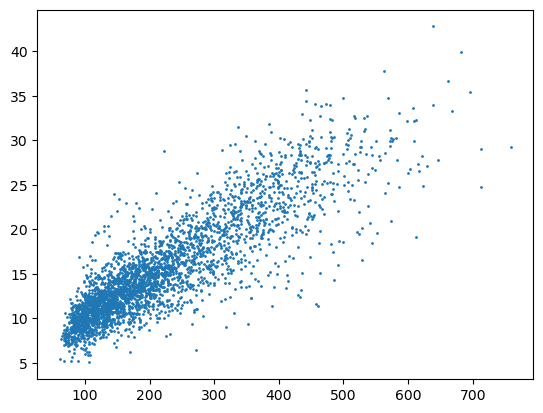

In [53]:
dum = plt.scatter(intime.area,intime.peak,s=1)

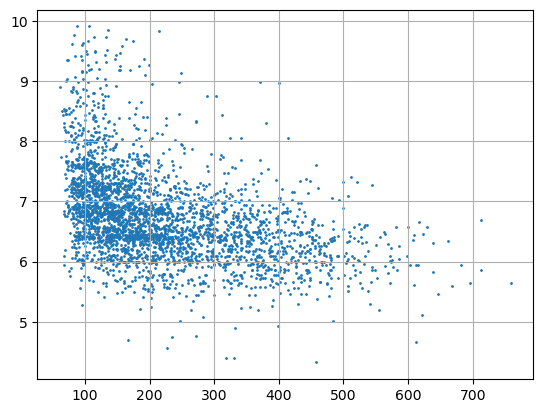

In [54]:
plt.scatter(intime.area,intime.period_itime,s=1)
plt.grid()

(array([857., 689., 653., 455., 272., 153.,  60.,  39.,  23.,   9.]),
 array([ 3.6 ,  4.88,  6.16,  7.44,  8.72, 10.  , 11.28, 12.56, 13.84,
        15.12, 16.4 ]),
 <BarContainer object of 10 artists>)

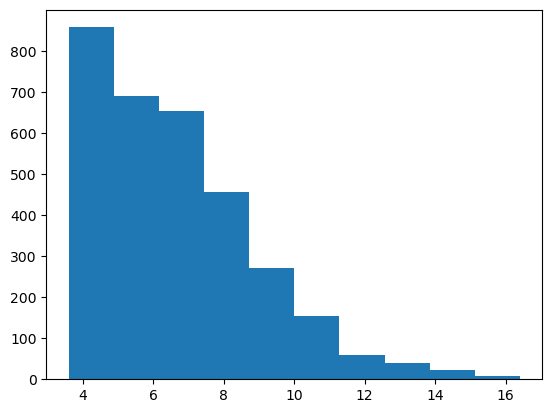

In [55]:
plt.hist(intime.tot)

(0.0, 30.0)

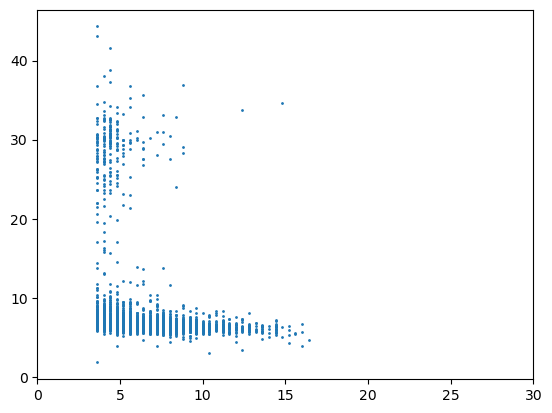

In [56]:
plt.scatter(hit_df.tot,hit_df.period_itime,s=1)
plt.xlim(0,30.)